# Reclassifying

Find areas which meet certain criteria such as distance, housing cost, etc.

In this case: accessibility to center but further away where there are lower prices.

In [1]:
import geopandas as gpd

In [2]:
accessibility_grid = gpd.read_file('../data/agis/data/helsinki_region_travel_times_to_railway_station/helsinki_region_travel_times_to_railway_station.gpkg')

In [3]:
accessibility_grid.columns

Index(['car_m_d', 'car_m_t', 'car_r_d', 'car_r_t', 'from_id', 'pt_m_d',
       'pt_m_t', 'pt_m_tt', 'pt_r_d', 'pt_r_t', 'pt_r_tt', 'to_id', 'walk_d',
       'walk_t', 'geometry'],
      dtype='object')

>- 'pt_r_tt`: time in minutes to city center
>- `walk_d`: distance along road network to center

In [4]:
accessibility_grid = accessibility_grid.loc[accessibility_grid.pt_r_tt >= 0]

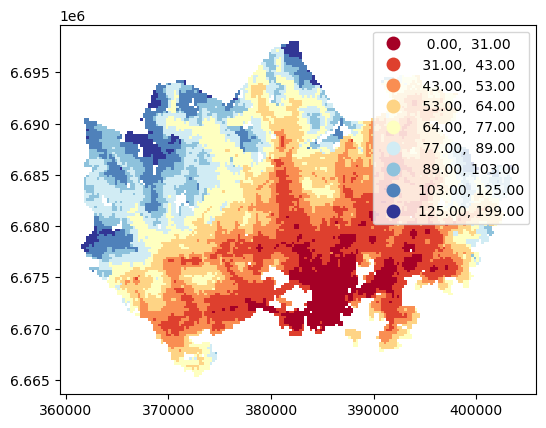

In [5]:
accessibility_grid.plot(
    column='pt_r_tt', 
    scheme='Natural_Breaks', 
    k=9, 
    cmap='RdYlBu', 
    linewidth=0, 
    legend=True
);

In [7]:
accessibility_grid = accessibility_grid.loc[accessibility_grid.walk_d >= 0]

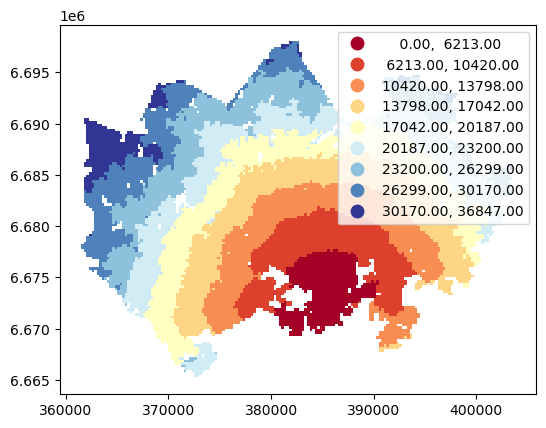

In [8]:
accessibility_grid.plot(
    column='walk_d', 
    scheme='Natural_Breaks', 
    k=9, 
    cmap='RdYlBu', 
    linewidth=0, 
    legend=True
);

# Applying Classifiers

In [9]:
import mapclassify

In [10]:
mapclassify.NaturalBreaks(y=accessibility_grid.pt_r_tt, k=9)

NaturalBreaks

    Interval       Count
------------------------
[  0.00,  30.00] |   837
( 30.00,  43.00] |  2361
( 43.00,  54.00] |  2453
( 54.00,  65.00] |  2063
( 65.00,  78.00] |  1759
( 78.00,  92.00] |  1694
( 92.00, 108.00] |  1087
(108.00, 129.00] |   557
(129.00, 199.00] |   182

In [11]:
mapclassify.Quantiles(y=accessibility_grid.pt_r_tt)

Quantiles

    Interval       Count
------------------------
[  0.00,  41.00] |  2674
( 41.00,  52.00] |  2576
( 52.00,  66.00] |  2598
( 66.00,  85.00] |  2614
( 85.00, 199.00] |  2531

In [12]:
classifier = mapclassify.NaturalBreaks(y=accessibility_grid.pt_r_tt, k=9) 
classifier.bins

array([ 27.,  39.,  51.,  64.,  77.,  89., 103., 125., 199.])

>Initialize a classifier to apply/classify the times

In [13]:
classifier = mapclassify.NaturalBreaks.make(k=9)

In [14]:
classifications = accessibility_grid[['pt_r_tt']].apply(classifier)
classifications.head()

,pt_r_tt
0,8
1,8
2,8
3,8
4,7


In [15]:
accessibility_grid['nb_pt_r_tt'] = accessibility_grid[['pt_r_tt']].apply(classifier)
accessibility_grid[['pt_r_tt', 'nb_pt_r_tt']].head()

,pt_r_tt,nb_pt_r_tt
0,139,8
1,133,8
2,133,8
3,144,8
4,121,7


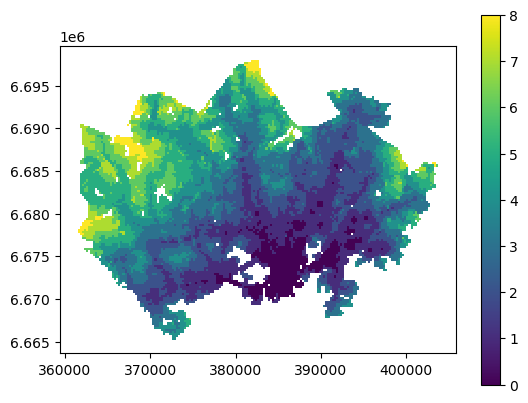

In [16]:
accessibility_grid.plot(column='nb_pt_r_tt', 
                        linewidth=0, 
                        legend=True);

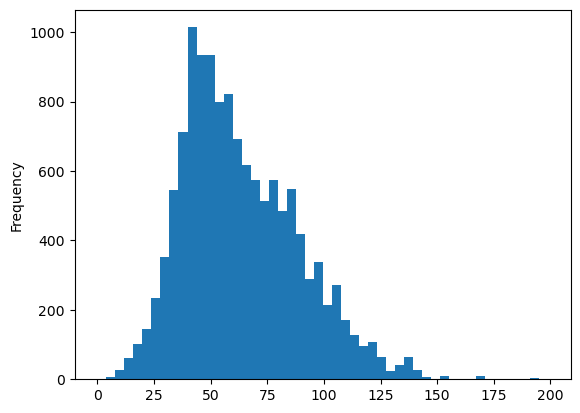

In [17]:
accessibility_grid.pt_r_tt.plot.hist(bins=50);

In [18]:
import matplotlib.pyplot as plt

In [19]:
classifier = mapclassify.NaturalBreaks(
    y=accessibility_grid.pt_r_tt, k=9
)

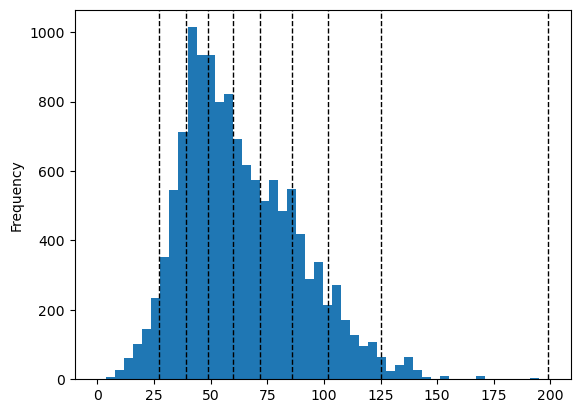

In [20]:
accessibility_grid.pt_r_tt.plot.hist(bins=50)
for break_point in classifier.bins: 
    plt.axvline(break_point, color='k', 
               linestyle='dashed', linewidth=1);

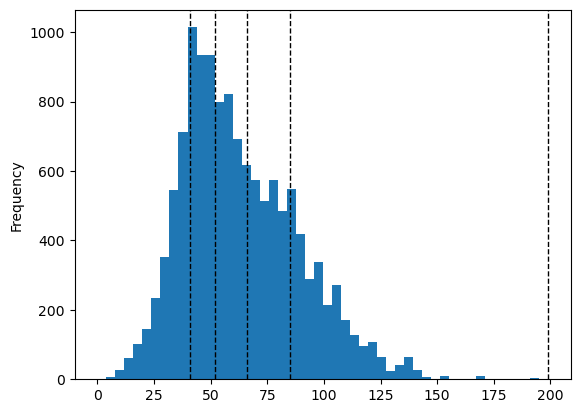

In [23]:
classifier = mapclassify.Quantiles(y=accessibility_grid['pt_r_tt'])

accessibility_grid["pt_r_tt"].plot.hist(bins=50)

for break_point in classifier.bins:
    plt.axvline(break_point, color="k", linestyle="--", linewidth=1);

# Multicriteria classification

>1. travel time to center lower or equal to 20 minutes
>2. further away than 4 km from center

In [24]:
accessibility_grid['suitable_area'] = accessibility_grid.apply(
    lambda row: int(row['pt_r_tt'] < 20 and row['walk_d'] > 4000), 
    axis=1
)

In [26]:
accessibility_grid.suitable_area.value_counts()

suitable_area
0    12984
1        9
Name: count, dtype: int64

In [30]:
import contextily as ctx

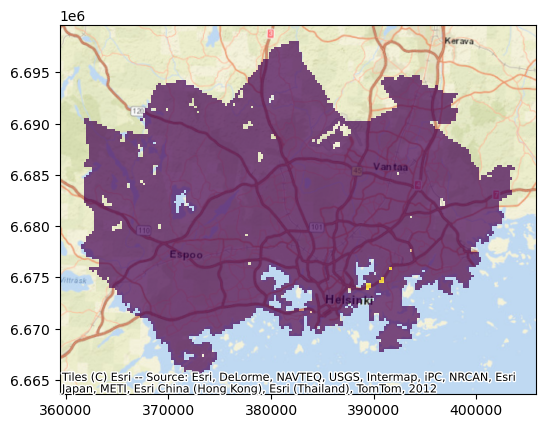

In [31]:
ax = accessibility_grid.plot(column='suitable_area', linewidth=0, alpha=.7)
ctx.add_basemap(ax, crs=accessibility_grid.crs, 
               source=ctx.providers.Esri.WorldStreetMap);